## Frequent Token Distribution

In [18]:
import pandas as pd
from ast import literal_eval
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from logitlens import LogitLens

model_name = "meta-llama/Llama-2-7b-chat-hf"
    # "google/gemma-3-12b-it"
    # "meta-llama/Llama-2-7b-chat-hf",
    # "Tower-Babel/Babel-9B-Chat"

logit_lens = LogitLens("English", model_name)
model_name_short = model_name.split("/")[-1]

df = pd.read_csv(f"/home/hyujang/multilingual-inner-lexicon/output/RQ1/WordIdentity/single_token_simple_split_{model_name_short}_English_v3.csv")

for col in df.columns:
    try:
        # Check if at least one value looks like a list
        if df[col].apply(lambda x: isinstance(x, str) and x.strip().startswith("[")).any():
            df[col] = df[col].apply(literal_eval)
    except (ValueError, SyntaxError):
        continue  # Skip columns that don't parse correctly

# Get all token ID and string columns
id_cols = [col for col in df.columns if col.startswith("layer_") and col.endswith("_top_token_id")]
str_cols = [col for col in df.columns if col.startswith("layer_") and col.endswith("_top_token_str")]

# Make sure they're in the same order
id_cols.sort()
str_cols.sort()

# Initialize the mapping dictionary
token_id_to_str = {}

# Iterate through layers
for id_col, str_col in zip(id_cols, str_cols):
    for id_list, str_list in zip(df[id_col], df[str_col]):
        for token_id, token_str in zip(id_list, str_list):
            if token_id not in token_id_to_str:
                token_id_to_str[token_id] = token_str


token_str_cols = [col for col in df.columns if col.startswith("layer_") and col.endswith("_top_token_id")]

# Flatten all top-3 token outputs across layers and words
all_tokens = []

for col in token_str_cols:
    for token_list_str in df[col]:
        try:
            all_tokens.extend(token_list_str)
        except:
            continue

top_20_tokens = [tok for tok, _ in Counter(all_tokens).most_common(20)]

# Step 2: Count frequency of each top token per layer
layer_token_freq = pd.DataFrame(index=top_20_tokens, columns=token_str_cols)

for col in token_str_cols:
    token_counts = Counter()
    for token_list_str in df[col]:
        try:
            token_counts.update(token_list_str)
        except:
            continue
    for tok in top_20_tokens:
        layer_token_freq.at[tok, col] = token_counts.get(tok, 0)

# Convert to numeric
layer_token_freq = layer_token_freq.fillna(0).astype(int)

# Rename index using token strings
layer_token_freq.index = layer_token_freq.index.astype(int)
token_id_to_str = {int(k): logit_lens.tokenizer.convert_ids_to_tokens(k).encode('utf-8').decode('utf-8') for k, v in token_id_to_str.items()}
layer_token_freq.rename(index=token_id_to_str, inplace=True)

# Optional: clean column names (layer_1 -> 1, etc.)
layer_token_freq.columns = [int(col.split("_")[1]) for col in layer_token_freq.columns]

import matplotlib

# Use a font that supports wide Unicode range
# matplotlib.rcParams['font.family'] = 'Noto Sans'


# # Step 3: Plot
# plt.figure(figsize=(25, 10))
# sns.heatmap(layer_token_freq, annot=True, fmt='d', cmap="YlOrBr")
# plt.title(f"Top 30 Most Frequent Predicted Tokens by Layer ({model_name_short}, English)")
# plt.xlabel("Layer")
# plt.ylabel("Predicted Token")
# plt.tight_layout()
# plt.show()

Using device: cuda


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Model meta-llama/Llama-2-7b-chat-hf with dtype torch.float16 loaded successfully on cuda


/tmp/ipykernel_649895/1417006451.py:73: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [19]:
import plotly.express as px
import pandas as pd

# Suppose layer_token_freq is a DataFrame with layers as columns and tokens as index
df = layer_token_freq.reset_index().melt(id_vars='index', var_name='Layer', value_name='Count')
df.rename(columns={'index': 'Token'}, inplace=True)

fig = px.imshow(
    layer_token_freq.values,
    x=layer_token_freq.columns,  # Layers
    y=layer_token_freq.index,    # Tokens
    text_auto=True,
    aspect="auto",
    color_continuous_scale="YlOrBr"
)

fig.update_layout(
    title=f"Top 20 Most Frequent Predicted Tokens by Layer ({model_name_short}, English)",
    xaxis_title="Layer",
    yaxis_title="Predicted Token ",
    width=1200,   # figure width in pixels
    height=500    # figure height in pixels

)

fig.show()


## Diagnosing Rogue Diemnsion via Anisotropy

In [1]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from logitlens import LogitLens
import pandas as pd
import matplotlib.pyplot as plt
import ast

Processing model: google/gemma-3-12b-it
Using device: cuda


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Model google/gemma-3-12b-it with dtype torch.bfloat16 loaded successfully on cuda


100%|██████████| 700/700 [00:53<00:00, 13.09it/s]


Processing model: meta-llama/Llama-2-7b-chat-hf
Using device: cuda


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Model meta-llama/Llama-2-7b-chat-hf with dtype torch.float16 loaded successfully on cuda


100%|██████████| 700/700 [00:17<00:00, 40.53it/s]


Processing model: Tower-Babel/Babel-9B-Chat
Using device: cuda


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Model Tower-Babel/Babel-9B-Chat with dtype torch.bfloat16 loaded successfully on cuda


100%|██████████| 700/700 [00:21<00:00, 32.66it/s]


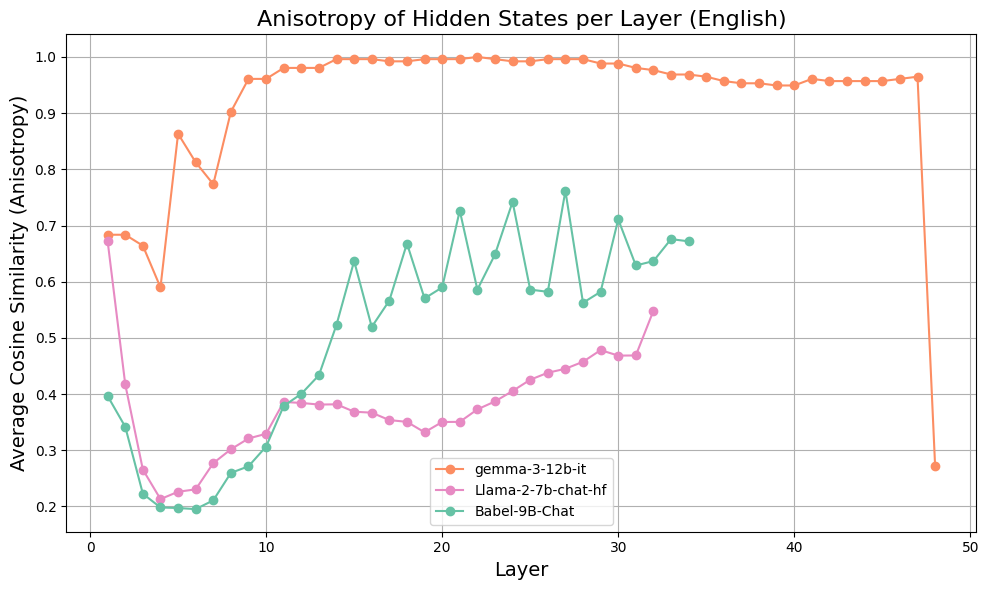

In [7]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Define the models and language
models = [
    "google/gemma-3-12b-it",
    "meta-llama/Llama-2-7b-chat-hf",
    "Tower-Babel/Babel-9B-Chat"
]
language = "English"

# Function to measure anisotropy
def measure_anisotropy(hidden_matrix: torch.Tensor, sample_size=1000):
    normed = F.normalize(hidden_matrix, dim=-1)
    N = normed.size(0)
    idx1 = torch.randint(0, N, (sample_size,))
    idx2 = torch.randint(0, N, (sample_size,))
    sims = (normed[idx1] * normed[idx2]).sum(dim=1)
    return sims.mean().item()

# Initialize a dictionary to store anisotropy values for each model
anisotropy_data = {}

for model_name in models:
    print(f"Processing model: {model_name}")
    logit_lens = LogitLens(language, model_name)
    model_short_name = model_name.split("/")[-1]
    
    # Load the data for the model
    path = f"/home/hyujang/multilingual-inner-lexicon/data/RQ1/WordIdentity/single_token_splitted_{model_short_name}_{language}_v2.csv"
    df = pd.read_csv(path)
    
    # Run the logit lens and get hidden states
    hidden_states_results = logit_lens.run_logit_lens(df, split_type="simple_split", return_hidden_states=True)
    all_hiddens_dict = {result["word"]: result["all_hidden_states"] for result in hidden_states_results}
    
    num_layers = len(next(iter(all_hiddens_dict.values())))  # Get the number of layers
    anisotropy_per_layer = []

    for layer_idx in range(num_layers):
        # Collect hidden states for the current layer across all words
        layer_hiddens = torch.stack([h[layer_idx] for h in all_hiddens_dict.values()])
        anisotropy = measure_anisotropy(layer_hiddens)
        anisotropy_per_layer.append(anisotropy)
    anisotropy_data[model_short_name] = anisotropy_per_layer
    
# Plot anisotropy for all models
model_colors = {
    "Babel-9B-Chat": "#66c2a5",
    "gemma-3-12b-it": "#fc8d62",
    "Llama-2-7b-chat-hf": "#e78ac3"
}

plt.figure(figsize=(10, 6))
for model_short_name, anisotropy_per_layer in anisotropy_data.items():
    plt.plot(
        range(1, len(anisotropy_per_layer) + 1),
        anisotropy_per_layer,
        marker='o',
        label=model_short_name,
        color=model_colors[model_short_name]
    )

# Customize the plot
plt.xlabel("Layer", fontsize=14)
plt.ylabel("Average Cosine Similarity (Anisotropy)", fontsize=14)
plt.title("Anisotropy of Hidden States per Layer (English)", fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Processing model: google/gemma-3-12b-it
Using device: cuda


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Model google/gemma-3-12b-it with dtype torch.bfloat16 loaded successfully on cuda


100%|██████████| 700/700 [00:53<00:00, 13.00it/s]


Processing model: meta-llama/Llama-2-7b-chat-hf
Using device: cuda


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Model meta-llama/Llama-2-7b-chat-hf with dtype torch.float16 loaded successfully on cuda


100%|██████████| 700/700 [00:17<00:00, 40.52it/s]


Processing model: Tower-Babel/Babel-9B-Chat
Using device: cuda


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Model Tower-Babel/Babel-9B-Chat with dtype torch.bfloat16 loaded successfully on cuda


100%|██████████| 700/700 [00:21<00:00, 32.09it/s]


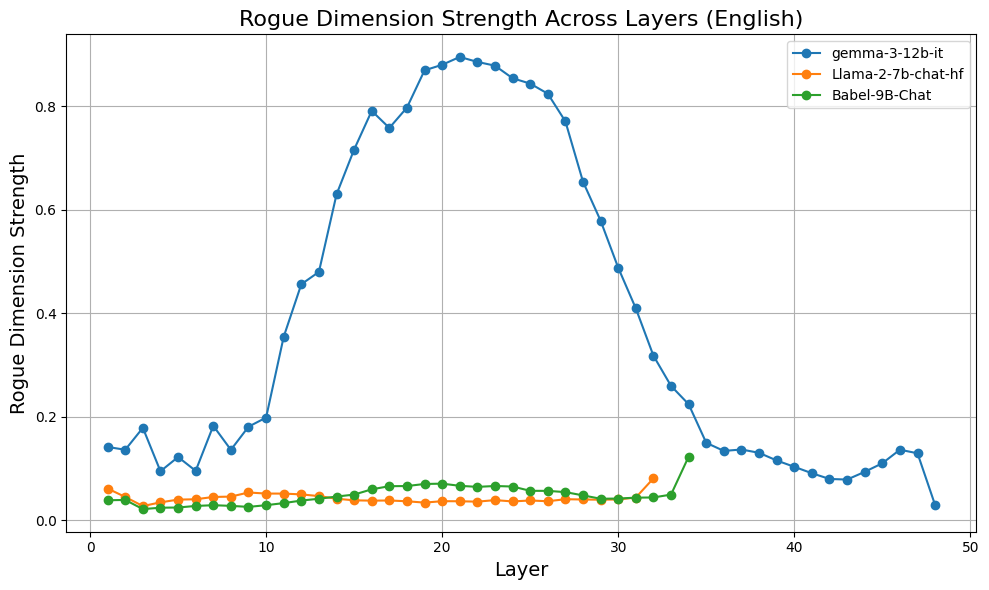

In [ ]:
import torch
import matplotlib.pyplot as plt

# Define the models and language
models = [
    "google/gemma-3-12b-it",
    "meta-llama/Llama-2-7b-chat-hf",
    "Tower-Babel/Babel-9B-Chat"
]
language = "English"

# Function to compute rogue dimension strength
def compute_rogue_dimension_strength(layer_hiddens):
    """
    layer_hiddens: torch.Tensor of shape [num_words, hidden_dim]
    returns: float, rogue dimension strength
    """
    layer_hiddens = layer_hiddens.float()
    # Ensure at least 2D
    if layer_hiddens.ndim == 1:
        layer_hiddens = layer_hiddens.unsqueeze(0)
    # Center hidden states
    hidden_centered = layer_hiddens - layer_hiddens.mean(dim=0, keepdim=True)
    # Covariance matrix
    cov = (hidden_centered.T @ hidden_centered) / (hidden_centered.shape[0] - 1)
    # Eigenvalues
    eigvals, _ = torch.linalg.eigh(cov)
    eigvals = eigvals.flip(dims=[0])
    # Rogue dimension strength
    ratio = eigvals[0] / eigvals.sum()
    return ratio.item()

# Initialize a dictionary to store rogue dimension strengths for each model
rogue_strength_data = {}

for model_name in models:
    print(f"Processing model: {model_name}")
    logit_lens = LogitLens(language, model_name)
    model_short_name = model_name.split("/")[-1]
    
    # Load the data for the model
    path = f"/home/hyujang/multilingual-inner-lexicon/data/RQ1/WordIdentity/single_token_splitted_{model_short_name}_{language}_v2.csv"
    df = pd.read_csv(path)
    
    # Run the logit lens and get hidden states
    hidden_states_results = logit_lens.run_logit_lens(df, split_type="simple_split", return_hidden_states=True)
    all_hiddens_dict = {result["word"]: result["all_hidden_states"] for result in hidden_states_results}
    
    num_layers = len(next(iter(all_hiddens_dict.values())))  # Get the number of layers
    rogue_strengths = []

    for layer_idx in range(num_layers):
        # Collect hidden states for the current layer across all words
        layer_hiddens = torch.stack([h[layer_idx] for h in all_hiddens_dict.values()])
        rogue_strength = compute_rogue_dimension_strength(layer_hiddens)
        rogue_strengths.append(rogue_strength)
    rogue_strength_data[model_short_name] = rogue_strengths

# Plot rogue dimension strength for all models
plt.figure(figsize=(10, 6))
for model_short_name, rogue_strengths in rogue_strength_data.items():
    plt.plot(
        range(1, len(rogue_strengths) + 1),
        rogue_strengths,
        marker='o',
        label=model_short_name
    )

# Customize the plot
plt.xlabel("Layer", fontsize=14)
plt.ylabel("Rogue Dimension Strength", fontsize=14)
plt.title("Rogue Dimension Strength Across Layers (English)", fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

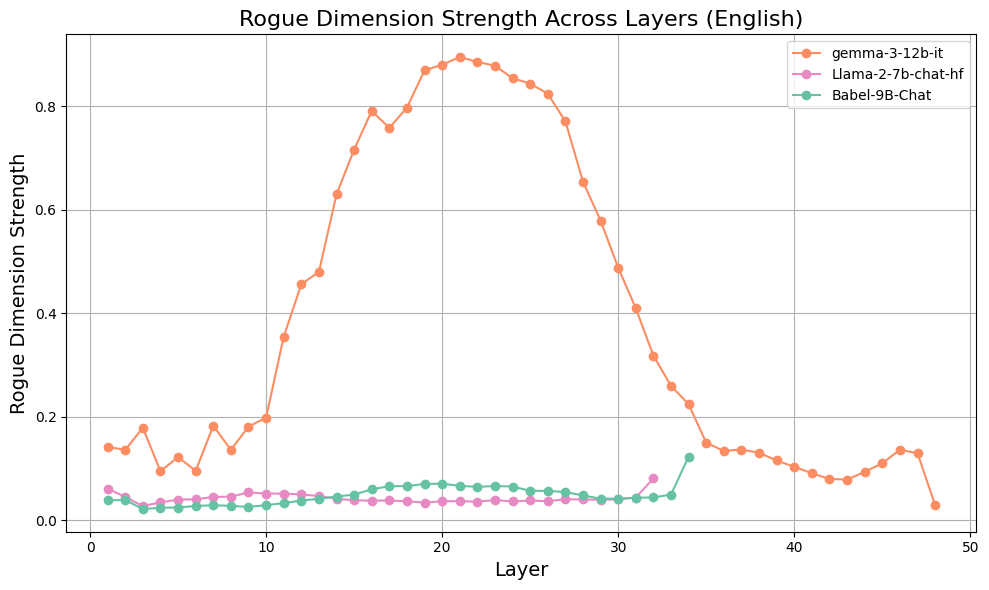

In [10]:
# Plot rogue dimension strength for all models
plt.figure(figsize=(10, 6))
for model_short_name, rogue_strengths in rogue_strength_data.items():
    plt.plot(
        range(1, len(rogue_strengths) + 1),
        rogue_strengths,
        marker='o',
        label=model_short_name,
        color=model_colors[model_short_name]
    )

# Customize the plot
plt.xlabel("Layer", fontsize=14)
plt.ylabel("Rogue Dimension Strength", fontsize=14)
plt.title("Rogue Dimension Strength Across Layers (English)", fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Individual Models

In [ ]:
# MODEL_NAME = "google/gemma-3-12b-it"
MODEL_NAME = "meta-llama/Llama-2-7b-chat-hf"
# MODEL_NAME = "Tower-Babel/Babel-9B-Chat"

LANGUAGE = "English"
logit_lens = LogitLens(LANGUAGE, MODEL_NAME)
MODEL_NAME = MODEL_NAME.split("/")[-1]
path1 = f"/home/hyujang/multilingual-inner-lexicon/data/RQ1/WordIdentity/single_token_splitted_{MODEL_NAME}_{LANGUAGE}_v2.csv"
df = pd.read_csv(path1)
all_hiddens, words = logit_lens.run_logit_lens(df, type="simple_split", return_hidden_states=True)

Using device: cuda


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Model meta-llama/Llama-2-7b-chat-hf for English loaded successfully.


100%|██████████| 700/700 [00:18<00:00, 37.04it/s]


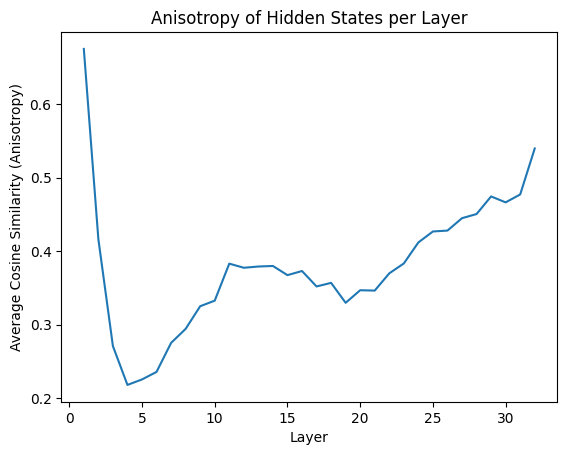

In [3]:
import torch
import torch.nn.functional as F

def measure_anisotropy(hidden_matrix: torch.Tensor, sample_size=1000):
    normed = F.normalize(hidden_matrix, dim=-1)
    N = normed.size(0)
    idx1 = torch.randint(0, N, (sample_size,))
    idx2 = torch.randint(0, N, (sample_size,))
    sims = (normed[idx1] * normed[idx2]).sum(dim=1)
    return sims.mean().item()

anisotropy_per_layer = [measure_anisotropy(h) for h in all_hiddens]

import matplotlib.pyplot as plt
plt.plot(range(1, len(anisotropy_per_layer)+1), anisotropy_per_layer)
plt.xlabel("Layer")
plt.ylabel("Average Cosine Similarity (Anisotropy)")
plt.title("Anisotropy of Hidden States per Layer")
plt.show()


In [4]:
logits_per_layer = []
top_tokens_per_layer = []

for layer_idx, hidden in enumerate(all_hiddens):
    # hidden: [700, 3840]
    # Logits: [700, vocab_size]
    logits = torch.matmul(hidden.to(logit_lens.device), logit_lens.embedding_matrix.T)  # matmul hidden * embedding.T
    logits_per_layer.append(logits.cpu())

    # Top token ids per example in batch for this layer
    top_tokens = torch.argmax(logits, dim=-1).cpu().numpy()  # shape: (700,)
    top_tokens_per_layer.append(top_tokens)

def entropy(logits):
    probs = F.softmax(logits, dim=-1)
    return (-probs * probs.log()).sum(dim=-1).mean().item()  # mean entropy over batch

entropy_per_layer = [entropy(logits) for logits in logits_per_layer]


In [5]:
import numpy as np
top_tokens_per_layer = np.array(top_tokens_per_layer)  # shape: (48, 700)

# For each word, check if predicted token is the same across all layers
same_token_across_layers = np.all(top_tokens_per_layer == top_tokens_per_layer[0, :], axis=0)
batch_size = all_hiddens[0].shape[0]


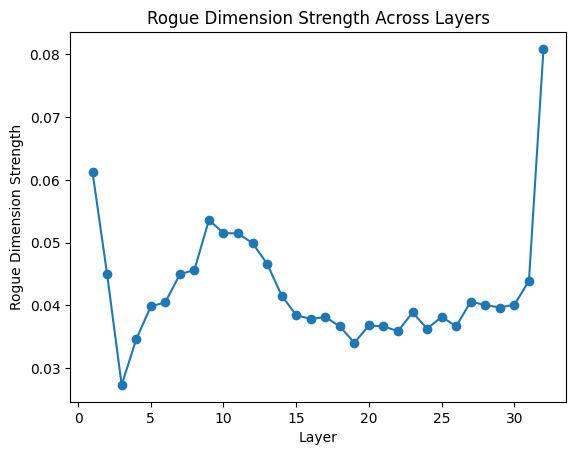

: 

In [ ]:
rogue_strengths = []

for layer_idx, hidden in enumerate(all_hiddens):
    # Convert to float32 if needed
    hidden = hidden.float()  # avoid bfloat16 issue
    
    hidden_centered = hidden - hidden.mean(dim=0, keepdim=True)  # [700, 3840]
    # The covariance matrix captures how each dimension of the hidden vectors varies and co-varies with others across tokens
    cov = (hidden_centered.T @ hidden_centered) / (hidden_centered.shape[0] - 1)  # [3840, 3840] 
    
    eigvals, eigvecs = torch.linalg.eigh(cov)
    eigvals = eigvals.flip(dims=[0])  # descending order
    
    ratio = eigvals[0] / eigvals.sum()
    rogue_strengths.append(ratio.item())

# Plot rogue_strengths with matplotlib (using Python floats, so no np needed)
import matplotlib.pyplot as plt
plt.plot(range(1, len(rogue_strengths)+1), rogue_strengths, marker='o')
plt.xlabel('Layer')
plt.ylabel('Rogue Dimension Strength')
plt.title('Rogue Dimension Strength Across Layers')
plt.show()